<a href="https://colab.research.google.com/github/nathan-tw/Data-Science-for-Cybersecurity/blob/master/Zero_access.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ZeroAccess

* Where ZeroAccess occurs? Any patterns?
* What kind of users are easily to be infected? Does education or income affect infection rate?
* Does UFO cause ZeroAccess infection?



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
z_df = pd.read_csv("https://drive.google.com/uc?id=1LRgxN2ArFB82VbqloPyXTKU37gxFM5Hx") # zeroaccess.csv
s_df = pd.read_csv("https://drive.google.com/uc?id=1PZgOIwkrISYp8r3xdA-DrWkyOx1TZgy_") # state-internets.csv
c_df = pd.read_csv("https://drive.google.com/uc?id=1PsrGcWk0v89Tce8W-LhwMGrdtbFzYeMT") # county-data.csv

In [3]:
print(z_df.shape, s_df.shape, c_df.shape)

(808446, 2) (49, 3) (3072, 6)


In [4]:
z_df.head()

,lat,long
0,-10.0000,-55.0000
1,38.0888,-78.5592
2,38.9990,-84.6266
3,48.6210,7.4944
4,43.2342,-86.2484


In [5]:
s_df.head()

,state,population,internet
0,Alabama,4758191,3092273
1,Arizona,6665093,5230474
2,Arkansas,2919815,1949869
3,California,37350092,29758896
4,Colorado,5077553,4058749


In [6]:
c_df.head()

,subregion,region,pop,income,ipaddr,ufo2010
0,abbeville,south carolina,25101,34670,30330,2
1,acadia,louisiana,61912,37970,38203,6
2,accomack,virginia,33341,41595,41338,2
3,ada,idaho,409061,55304,1035427,59
4,adair,iowa,7481,47623,3762,0


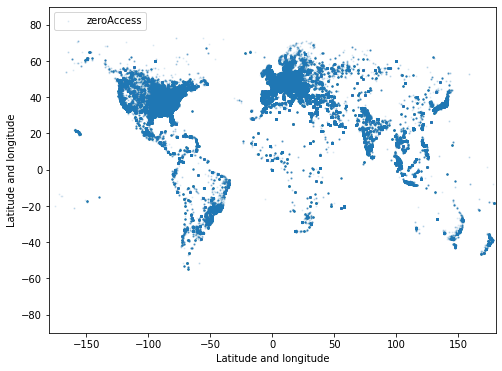

In [7]:
# plot zeroAccess infection instances on a earth map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.scatter(z_df.long, z_df.lat, alpha = 0.1, s = 1, label = "zeroAccess")
ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))

plt.xlabel("Latitude and longitude")
plt.ylabel("Latitude and longitude")
plt.legend(loc='upper left')

plt.show()

In [8]:
import folium
from folium.plugins import HeatMap
mapa = folium.Map(location=(10, 10), zoom_start=1.5, tiles="Stamen Toner", height="50%", width="50%")
loc_li = list(zip(z_df.lat, z_df.long))[:10000] # <--- change data size
HeatMap(loc_li, radius=15).add_to(mapa) # <-----------------------change radius
mapa

### Reverse Geocoding



In [9]:
!pip install reverse_geocoder

     |████████████████████████████████| 2.3MB 2.8MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-cp36-none-any.whl size=2268091 sha256=f49bedb1bca38b3a762ef41b27031bd5fa8bb5b986c9ebf793252b1d7703c272
  Stored in directory: /root/.cache/pip/wheels/47/05/50/b1350ff094ef91e082665b4a2f9ca551f8acea4aa55d796b26
Successfully built reverse-geocoder


In [0]:
import reverse_geocoder

# {'lat': '51.51116', 'lon': '-0.18426', 'name': 'Bayswater', 
#  'admin1': 'England', 'admin2': 'Greater London', 'cc': 'GB'}

# batch implementation
def rgr_batch(lat_long_df):
  cord_li = []
  for ind in lat_long_df.index:
    cord_li.append((lat_long_df['lat'][ind], lat_long_df['long'][ind]))
  result_dict_li = reverse_geocoder.search(cord_li)
  return pd.DataFrame(result_dict_li).drop(["lat", "lon"], axis = 1)

In [11]:
# batch implementation
sample_df = z_df.head(50000) # <------ only use some data, because it takes time
country_df = rgr_batch(sample_df)
df = sample_df.join(country_df).rename(columns={'name':'City', 'admin1': 'State', 'admin2':'County', 'cc':"country_code", })
df

Loading formatted geocoded file...


,lat,long,City,State,County,country_code
0,-10.0000,-55.0000,Alta Floresta,Mato Grosso,Alta Floresta,BR
1,38.0888,-78.5592,Charlottesville,Virginia,City of Charlottesville,US
2,38.9990,-84.6266,Florence,Kentucky,Boone County,US
3,48.6210,7.4944,Marlenheim,Alsace,Departement du Bas-Rhin,FR
4,43.2342,-86.2484,Muskegon,Michigan,Muskegon County,US
...,...,...,...,...,...,...
49995,53.1271,18.0200,Bydgoszcz,Kujawsko-Pomorskie,Bydgoszcz,PL
49996,42.6757,-82.7773,New Baltimore,Michigan,Macomb County,US
49997,43.5417,21.7078,Aleksinac,Central Serbia,Nisavski Okrug,RS
49998,28.2397,-82.7388,New Port Richey,Florida,Pasco County,US


### Question #1:
Plot a figure to show # of attack in each country

In [12]:
country = df.groupby('country_code').size().sort_values(ascending=False)
country.head()

country_code
US    23987
CA     2966
GB     2564
JP     1504
AU     1501
dtype: int64

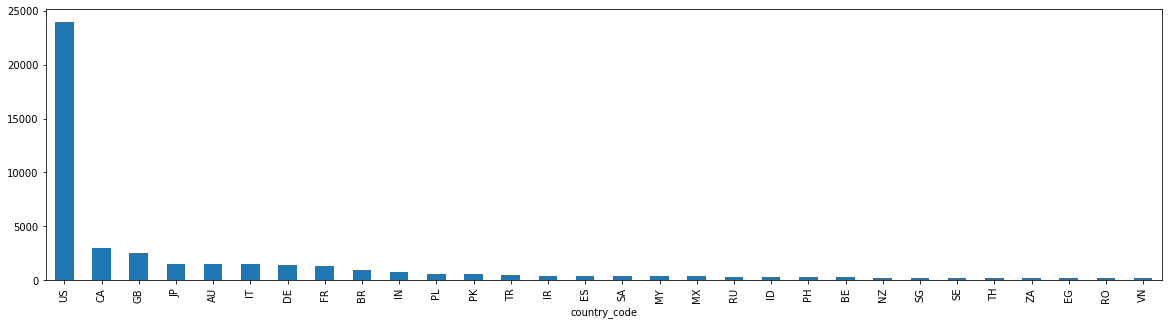

In [13]:
country[:30].plot.bar(figsize=(20, 5))

### Question #2:

Plot a figure to show % of attack in each country
Ignore countries that are < 1%

In [0]:
ratio = country/country.sum()
p = ratio[ratio>=0.01]

In [15]:
p

country_code
US    0.47974
CA    0.05932
GB    0.05128
JP    0.03008
AU    0.03002
IT    0.02964
DE    0.02824
FR    0.02622
BR    0.01928
IN    0.01496
PL    0.01154
PK    0.01096
TR    0.01052
dtype: float64

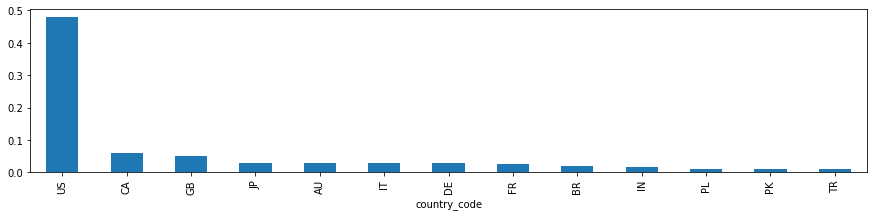

In [16]:
p.plot.bar(figsize=(15,3))

### Question #3:

Only show US data and map.
Show US state data.

Which state/city has severe attack? Why?

Hint: recall a network tool named 'whois' ...


In [0]:
US_df = df[df.country_code=='US']

In [18]:
US_df

,lat,long,City,State,County,country_code
1,38.0888,-78.5592,Charlottesville,Virginia,City of Charlottesville,US
2,38.9990,-84.6266,Florence,Kentucky,Boone County,US
4,43.2342,-86.2484,Muskegon,Michigan,Muskegon County,US
6,44.8012,-68.7778,Bangor,Maine,Penobscot County,US
8,36.0580,-88.8253,Bradford,Tennessee,Gibson County,US
...,...,...,...,...,...,...
49992,40.6374,-79.7264,Brackenridge,Pennsylvania,Allegheny County,US
49994,38.4380,-122.6753,Santa Rosa,California,Sonoma County,US
49996,42.6757,-82.7773,New Baltimore,Michigan,Macomb County,US
49998,28.2397,-82.7388,New Port Richey,Florida,Pasco County,US


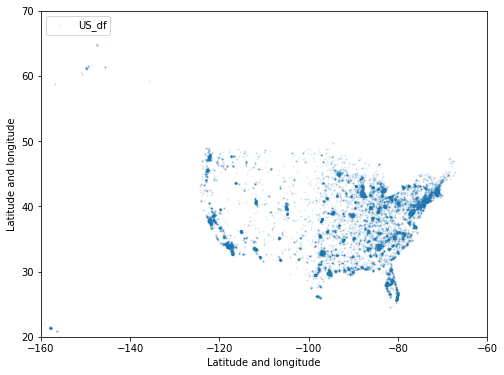

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.scatter(US_df.long, US_df.lat, alpha = 0.1, s = 1, label = "US_df")
ax.set_xlim((-160, -60))
ax.set_ylim((20, 70))

plt.xlabel("Latitude and longitude")
plt.ylabel("Latitude and longitude")
plt.legend(loc='upper left')

plt.show()

In [21]:
state = US_df.groupby('State').size().sort_values(ascending=False)
state

State
California          2293
Texas               2003
Florida             1425
Kansas              1371
New York            1315
Pennsylvania         970
Illinois             948
Ohio                 914
Georgia              841
North Carolina       759
Michigan             715
New Jersey           669
Virginia             526
Arizona              503
Washington           502
Missouri             480
Wisconsin            472
Indiana              458
Massachusetts        453
Maryland             430
Tennessee            425
Alabama              412
Minnesota            405
Colorado             394
South Carolina       386
Kentucky             373
Louisiana            366
Oklahoma             293
Arkansas             262
Mississippi          241
Oregon               235
Iowa                 228
Connecticut          226
Nevada               187
Utah                 164
West Virginia        161
Nebraska             144
New Mexico           133
Maine                113
Idaho              

In [20]:
city = US_df.groupby(['State', 'City']).size().sort_values(ascending=False)
city

State         City         
Kansas        Peabody          1152
Texas         Houston           238
California    Los Angeles       179
Illinois      Chicago           144
Arizona       Phoenix           142
                               ... 
Pennsylvania  Quarryville         1
              Radnor              1
Maryland      Hurlock             1
              Huntingtown         1
Mississippi   Ocean Springs       1
Length: 6660, dtype: int64

### Question #4:

Is there anything wrong with these states?

In [22]:
att_pc = state/state.sum()
pd.concat([state.rename('attact'), att_pc.rename('att_pc')], axis=1)

,attact,att_pc
State,,
California,2293,0.095593
Texas,2003,0.083504
Florida,1425,0.059407
Kansas,1371,0.057156
New York,1315,0.054821
Pennsylvania,970,0.040439
Illinois,948,0.039521
Ohio,914,0.038104
Georgia,841,0.035061


### Question #5:

Are the attack occurances in each state related to state population?

Try a bar chart!

In [0]:
s_df2 = s_df.set_index('state')
pop_pc = (s_df2.population/s_df2.population.sum()).sort_values(ascending=False)

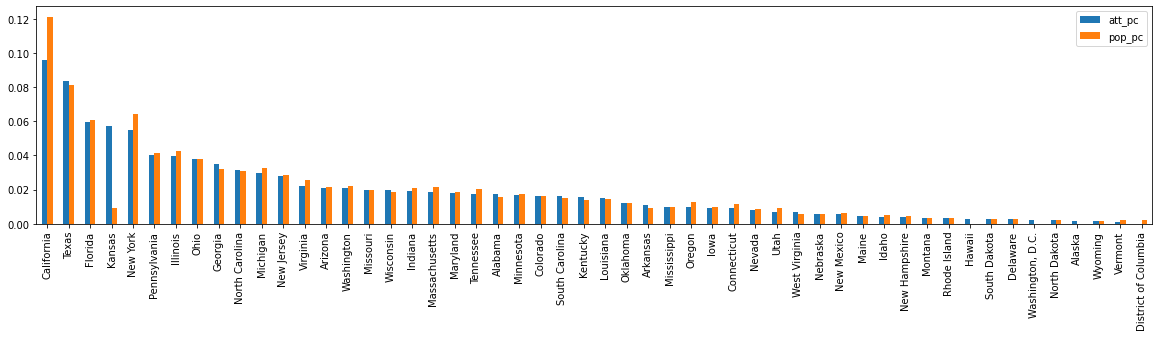

In [88]:
att_pop = pd.concat([state.rename('attack'), att_pc.rename('att_pc'), pop_pc.rename('pop_pc')], axis=1, sort=False)
att_pop[['att_pc', 'pop_pc']].plot.bar(figsize=(20,4))

### UFO?

Try to use county-data.csv data to predict the attack counts for each state by liner regression.

Which feature is the best?

In [0]:
county = c_df.drop(columns='subregion')

In [0]:
aggr_func = {i:'sum' for i in county.columns[1:]}
aggr_county = county.groupby(['region'],as_index=False).agg(aggr_func)
att_pop = att_pop.dropna(axis=0,how='any')
att_pop = att_pop.sort_index()
stateLowerCase = [each.lower() for each in att_pop.index]
att_pop = att_pop.set_index(pd.Index(stateLowerCase))

In [99]:
state_att = aggr_county.set_index('region').join(att_pop).dropna(axis=0,how='any')
state_att

,pop,income,ipaddr,ufo2010,attack,att_pc,pop_pc
region,,,,,,,
alabama,4822023,2522962,22542601,250,412.0,0.017176,0.015438
arizona,6532974,612727,62062174,1250,503.0,0.020970,0.021625
arkansas,2949131,2677866,4810526,265,262.0,0.010923,0.009473
california,38041430,3241756,156511903,3769,2293.0,0.095593,0.121181
colorado,5129284,3206281,22787577,513,394.0,0.016426,0.016474
connecticut,3590347,565060,40993589,280,226.0,0.009422,0.011535
delaware,917092,172156,19378182,74,68.0,0.002835,0.002902
florida,19317568,2990011,23716071,1465,1425.0,0.059407,0.060778
georgia,9919945,6433814,20947043,548,841.0,0.035061,0.032226


In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
x = state_att[['pop', 'income', 'ipaddr',	'ufo2010']]
y = state_att[['attack']]

In [104]:
regr = LinearRegression()
regr.fit(x, y)
regr_line = 'attack = {}*pop + {}*income + {}*ipaddr + {}*ufo2010 + {}'.format(regr.coef_[0][0],regr.coef_[0][1],regr.coef_[0][2],regr.coef_[0][3],regr.intercept_[0])
regr_line

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [123]:
import statsmodels.api as sm
results = sm.OLS(y, x).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 attack   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              199.5
Date:                Thu, 19 Mar 2020   Prob (F-statistic):                    1.38e-27
Time:                        08:13:53   Log-Likelihood:                         -311.51
No. Observations:                  48   AIC:                                      631.0
Df Residuals:                      44   BIC:                                      638.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pop         6.162e-05   9.98e-06      6.175      0.000    4.15e-05    8.17e-05
income      4.028e-05    1.1e-05      3.657      0.001    1.81e-05    6.25e-05
ipaddr      1.216e-07   7.38e-07      0.165      0.870   -1.37e-06    1.61e-06
ufo2010       -0.0333      0.103     -0.324      0.748      -0.241       0.174
==============================================================================
Omnibus:                       93.113   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2205.804
Skew:                           5.363   Prob(JB):                         0.00
Kurtosis:                      34.430   Cond. No.                     2.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Additional Materials

### GeoPy

Realtime network-based query. 
May limit query frequency.

https://geopy.readthedocs.io/en/stable/

In [0]:
!pip install geopy

In [0]:
import geopy

locator = geopy.geocoders.Nominatim(user_agent="myGeocoder")
coordinates = "53.480837, -2.244914"
location = locator.reverse(coordinates)
location.raw

{'address': {'building': 'Eagle Insurance Buildings',
  'city': 'Manchester',
  'country': 'United Kingdom',
  'country_code': 'gb',
  'county': 'Greater Manchester',
  'house_number': '68',
  'neighbourhood': 'Chinatown',
  'postcode': 'M2 4JG',
  'road': 'Cross Street',
  'state': 'England',
  'state_district': 'North West England',
  'suburb': 'City Centre'},
 'boundingbox': ['53.480856', '53.4810634', '-2.2451761', '-2.2449576'],
 'display_name': 'Eagle Insurance Buildings, 68, Cross Street, Chinatown, City Centre, Manchester, Greater Manchester, North West England, England, M2 4JG, United Kingdom',
 'lat': '53.4809597',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '-2.2450668274629235',
 'osm_id': 37139875,
 'osm_type': 'way',
 'place_id': 96393663}

### Reverse Geocode

In [0]:
!pip install reverse-geocode

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for reverse-geocode: filename=reverse_geocode-1.4-cp36-none-any.whl size=1637799 sha256=62b4d0ed626829f2d32c02d68fb3678aa53b7c66d12873ebf8b6b655f58893d7
  Stored in directory: /root/.cache/pip/wheels/80/56/82/529b8b1d91c1ef49fe335d89d61bc4d244b6ed72c5063c55e9
Successfully built reverse-geocode


In [0]:
# need a package that can convert lat,long to contury code
# https://pypi.org/project/reverse-geocode/

import reverse_geocode

coordinates = [(51.5214588, -0.1729636)]
results = reverse_geocode.search(coordinates)

print(results[0])

{'country_code': 'GB', 'city': 'Bayswater', 'country': 'United Kingdom'}


### Reverse Geocoder

https://github.com/thampiman/reverse-geocoder


In [0]:
 !pip install reverse_geocoder

     |████████████████████████████████| 2.3MB 2.7MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-cp36-none-any.whl size=2268091 sha256=b928e64e402af7f38e182b29363df26029479fa12c7a9fa049095c2149870813
  Stored in directory: /root/.cache/pip/wheels/47/05/50/b1350ff094ef91e082665b4a2f9ca551f8acea4aa55d796b26
Successfully built reverse-geocoder


In [0]:
import reverse_geocoder

coordinates = [(51.5214588, -0.1729636)]
results = reverse_geocoder.search(coordinates) # default mode = 2

print(dict(results[0]))

{'lat': '51.51116', 'lon': '-0.18426', 'name': 'Bayswater', 'admin1': 'England', 'admin2': 'Greater London', 'cc': 'GB'}
